# Performance Comparisons

We want to compare against several other packages on standard problems:

* GUDHI
* Dionysus
* Ripser
* TopologyLayer
* BATS standard with and without basis formation
* BATS clearing/compression optimizations (no basis)

Note TopologyLayer requires pytorch 1.1
```
conda install pytorch=1.1 -c pytorch
```

Dionysus and Gudhi can be installed via pip
```
pip install dionyusus gudhi
```

Write wrapper functions.  Take as input either two images or two metric spaces

In [1]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import time
from freudenthal import freudenthal_grid
import gudhi as gd
import dionysus as d

# Levelset Comparison

In [2]:
m = 200
n = 200

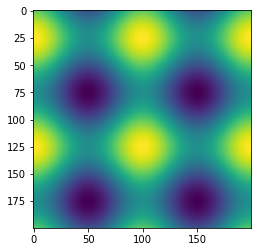

In [3]:
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

f2 = f + 0.01*np.random.randn(m,n)
plt.imshow(f);

### BATS update:

In [4]:
def time_BATS_update(img, img2):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    t1 = time.monotonic()
    print("time to extend: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.FilteredSimplicialComplex(X, vals)
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img2.flatten())
    R.update_filtration(vals)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
time_BATS_update(f, f2)

time to extend: 0.04038704402046278 sec.
time to construct: 0.07442566100507975 sec.
time to reduce: 1.2237217630026862 sec.
time to update: 0.1906067689997144 sec.


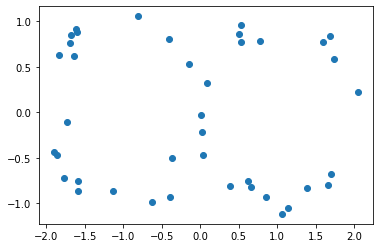

In [5]:
# first, generate two noisy circles
n = 40
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:20,0] = Y[:20,0] - 1
Y[20:,0] = Y[20:,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.01*np.random.randn(n,2)

In [6]:
def time_BATS_update_rips(X, Y):
    dist = bats.Euclidean()  # distance we would like to use
    
    data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
    data_Y = bats.DataSet(bats.Matrix(Y)) # put into a bats.DataSet
    
    t0 = time.monotonic()
    F_X = bats.RipsFiltration(data, dist, np.inf, 2) # generate a RipsFiltration
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R_X = bats.reduce(F_X, bats.F2()) # reduce with F2 coefficients
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F_Y = bats.RipsFiltration(data_Y, dist, np.inf, 2) # generate a RipsFiltration
    UI = bats.UpdateInfoFiltration(F_X, F_Y)
    R_X.update_filtration_general(UI)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
time_BATS_update_rips(Y, Y2)

time to construct: 0.014436968980589882 sec.
time to reduce: 0.019552996003767475 sec.
time to update: 0.030710077000549063 sec.


### BATS with flags

In [7]:
def time_BATS_flags(img, img2, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img2.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
    
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis",
    "standard w/ no basis",
    "standard w/ clearing",
    "standard w/ compression",
    "extra w/ basis",
    "extra w/ no basis",
    "extra w/ clearing",
    "extra w/ compression"
]
for flag, label in zip(flags, labels):
    print("\n{}:".format(label))
    time_BATS_flags(f, f2, flag)



standard w/ basis:
compute1: 1.1785819200158585 sec.
compute2: 1.2730603000090923 sec.

standard w/ no basis:
compute1: 0.3485326300142333 sec.
compute2: 0.40850302000762895 sec.

standard w/ clearing:
compute1: 0.20540500700008124 sec.
compute2: 0.25623605799046345 sec.

standard w/ compression:
compute1: 0.35845683197840117 sec.
compute2: 0.3982126170012634 sec.

extra w/ basis:
compute1: 1.1176212359860074 sec.
compute2: 1.2222999230143614 sec.

extra w/ no basis:
compute1: 0.48476418302743696 sec.
compute2: 0.4791048059996683 sec.

extra w/ clearing:
compute1: 0.21839329099748284 sec.
compute2: 0.31009112097672187 sec.

extra w/ compression:
compute1: 0.34807274499326013 sec.
compute2: 0.4168189679912757 sec.


### TopologyLayer:

In [8]:
from topologylayer.nn import LevelSetLayer2D
from topologylayer.nn import RipsLayer
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

In [9]:
m = 200
n = 200
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

f2 = f + 0.01*np.random.randn(m,n)

In [10]:
def time_toplayer(img, img2):
    
    layer = LevelSetLayer2D(size=img.shape)
    img_t = torch.tensor(img, dtype=torch.float, requires_grad=False)
    img2_t = torch.tensor(img2, dtype=torch.float, requires_grad=False)
    
    t0 = time.monotonic()
    pds = layer(img_t)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    pds = layer(img2_t)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

    
time_toplayer(f, f2)

compute1: 0.4513869640068151 sec.
compute2: 0.5204494369972963 sec.


### GUDHI: see http://gudhi.gforge.inria.fr/python/latest/simplex_tree_ref.html

In [11]:
def construct_gudhi_simplex_tree(img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    GT = gd.SimplexTree()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            GT.insert(s, v)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    return GT

def update_gudhi_simplex_tree(tree, img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            tree.assign_filtration(s, v)
    t1 = time.monotonic()
    print("update values: {} sec.".format(t1 - t0))
    return tree

def time_gudhi(img, img2):
    GT = construct_gudhi_simplex_tree(img)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    GT = update_gudhi_simplex_tree(GT, img2)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi(f, f2)

construction: 0.4186096850025933 sec.
compute1: 0.18910473698633723 sec.
update values: 0.48106492299120873 sec.
compute2: 0.21519648199318908 sec.


### Dionysus: https://mrzv.org/software/dionysus2/tutorial/lower-star.html

In [12]:
def time_dionysus(img, img2):
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img2)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
time_dionysus(f, f2)

construction: 0.36420314499991946 sec.
persistence: 0.3327757199876942 sec.
construction: 0.4754326999827754 sec.
persistence: 0.2772898539842572 sec.


# Rips Complex

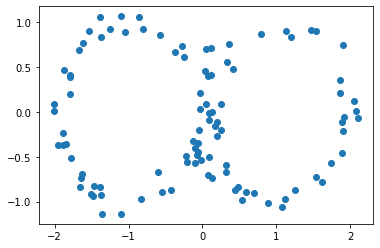

In [13]:
# first, generate two noisy circles
n = 100
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:(n//2),0] = Y[:(n//2),0] - 1
Y[(n//2):,0] = Y[(n//2):,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.005*np.random.randn(n,2)

In [15]:
# Don't run this for larger problems 
def time_toplayer_rips(y, y2):
    
    # layer = LevelSetLayer2D(size=img.shape)
    layer = RipsLayer(y.shape[0], maxdim=1) # maxdim is homology dimension
    y_t = torch.tensor(y, dtype=torch.float, requires_grad=False)
    y2_t = torch.tensor(y2, dtype=torch.float, requires_grad=False)
    
    t0 = time.monotonic()
    pds = layer(y_t)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    pds = layer(y2_t)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

    
time_toplayer_rips(Y, Y2)

compute1: 8.381071571988286 sec.
compute2: 8.324954397976398 sec.


Compared to TopologyLayer, BATs is much faster!!!! Rips Complex with 40 points in bats is faster than even 20 points in TopologyLayer!

It seems unnecessary for Gudhi to update simplex tree? (Need to write new python bindings for Updating information)

In [16]:
def time_gudhi_rips(X, Y):
    
    t0 = time.monotonic()
    rips_complex = gd.RipsComplex(points=X, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    # need to include setup
    rips_complex = gd.RipsComplex(points=Y, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi_rips(Y, Y2)

compute1: 0.09617861101287417 sec.
compute2: 0.07950186700327322 sec.


Gudhi seems to have a good performance. 

In [17]:
def time_dionysus_rips(X, Y):
    
    
    
    t0 = time.monotonic()
    f = d.fill_rips(X, 2, np.inf)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    f = d.fill_rips(Y, 2, np.inf)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
time_dionysus_rips(Y, Y2)

construction: 0.8705753200047184 sec.
persistence: 1.5009515930141788 sec.
construction: 0.9303114989888854 sec.
persistence: 1.1189310969784856 sec.


## Ripser

In [18]:
from ripser import ripser

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


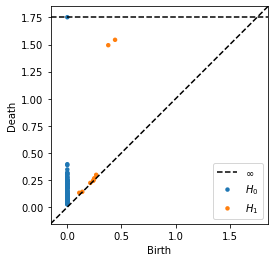

In [19]:
import numpy as np
from ripser import Rips

rips = Rips(maxdim=1)
diagrams = rips.fit_transform(Y)
rips.plot(diagrams)

In [20]:
def time_ripser_rips(X, Y, **kw):
    
    t0 = time.monotonic()
    out = ripser(X, **kw)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    out2 = ripser(Y, **kw)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

print("no basis")
time_ripser_rips(Y, Y2, maxdim=1)

print("with basis")
time_ripser_rips(Y, Y2, do_cocycles=True, maxdim=1)

no basis
compute1: 0.014160201011691242 sec.
compute2: 0.01381994498660788 sec.
with basis
compute1: 0.013894604984670877 sec.
compute2: 0.01340055899345316 sec.


## BATS

In [21]:
import scipy.spatial.distance as distance

def time_BATS_rips(X, Y):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = bats.enclosing_radius(bats.Matrix(DY))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    

time_BATS_rips(Y, Y2)

setup1: 0.002591222000773996 sec.
construct1: 0.028443506977055222 sec.
reduce1: 0.22918016099720262 sec.
setup2: 0.00020213000243529677 sec.
construct2: 0.023028808005619794 sec.
compute2: 0.23917616499238648 sec.


with flags...

In [22]:
def time_BATS_rips_flags(X, Y, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = bats.enclosing_radius(bats.Matrix(DY))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
    
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis",
    "standard w/ no basis",
    "standard w/ clearing",
    "standard w/ compression",
    "extra w/ basis",
    "extra w/ no basis",
    "extra w/ clearing",
    "extra w/ compression"
]
for flag, label in zip(flags, labels):
    print("\n{}:".format(label))
    time_BATS_rips_flags(Y, Y2, flag)


standard w/ basis:
setup1: 0.0006076160061638802 sec.
construct1: 0.024383526004385203 sec.
reduce1: 0.2341482490010094 sec.
setup2: 0.0011776830069720745 sec.
construct2: 0.03193811498931609 sec.
compute2: 0.25245212300796993 sec.

standard w/ no basis:
setup1: 0.0002808450080920011 sec.
construct1: 0.025912415992934257 sec.
reduce1: 0.12461034400621429 sec.
setup2: 0.00034231599420309067 sec.
construct2: 0.023196224006824195 sec.
compute2: 0.12726924000889994 sec.

standard w/ clearing:
setup1: 0.0006017969863023609 sec.
construct1: 0.023358701000688598 sec.
reduce1: 0.11811816299450584 sec.
setup2: 0.00022484900546260178 sec.
construct2: 0.023142089979955927 sec.
compute2: 0.1287720229884144 sec.

standard w/ compression:
setup1: 0.0002625859924592078 sec.
construct1: 0.024412619997747242 sec.
reduce1: 0.11567638200358488 sec.
setup2: 0.00018645101226866245 sec.
construct2: 0.022182423010235652 sec.
compute2: 0.13233949299319647 sec.

extra w/ basis:
setup1: 0.0002249089884571731 s

Now, let's do with updates

In [23]:
def time_BATS_updates_rips(X, Y):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = bats.enclosing_radius(bats.Matrix(DY))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    FY = bats.LightRipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    update_info = bats.UpdateInfoLightFiltration(F, FY)
    R.update_filtration_general(update_info)
    t1 = time.monotonic()
    print("update2: {} sec.".format(t1 - t0))
    

time_BATS_updates_rips(Y, Y2)

setup1: 0.0002264019858557731 sec.
construct1: 0.024035700014792383 sec.
reduce1: 0.24715175898745656 sec.
setup2: 0.0007699599955230951 sec.
construct2: 0.024273275019368157 sec.
update2: 0.09535754099488258 sec.
